## Data Discovery

In [28]:
import pandas as pd

#carrega os csvs para dataframes
videos = pd.read_csv('../data/videos.csv', quotechar='"', skipinitialspace=True)
video_views = pd.read_csv('../data/video_views.csv', quotechar='"', skipinitialspace=True)

video_views.shape
#video_views.usuario_id.unique().shape
#video_views.video_id.unique().shape

#videos.shape
#videos.video_id.unique().shape
#videos.programa_id.unique().shape

(759748, 4)

## Select only the views that contains "porcentagem_vista" not negative and less than 100

In [29]:
#remove valores negativos e as visualizações acima de 100
TEMP_video_views = video_views[(video_views.porcentagem_vista >= 0) & (video_views.porcentagem_vista < 100)]

TEMP_video_views.shape

(757834, 4)

## Select only the views that contains videos that also appears in videos.csv

In [30]:
#remove os vídeos que não estão presentes também no arquivo videos.csv
NORM_video_views = TEMP_video_views[TEMP_video_views.video_id.isin(videos.video_id)]

#grava arquivo csv
NORM_video_views.to_csv('../data/norm_video_views.csv', index = False)

NORM_video_views.shape

(736282, 4)

## Check the percentage of users vs quantity of videos

In [31]:
import time
import matplotlib.pyplot as plt
%matplotlib inline

#agrupa pelos ids de usuário
grouped_user = NORM_video_views.groupby(NORM_video_views.usuario_id)

#verifica a quantidade de videos que cada usuário assistiu
grouped_user_size = grouped_user.size() #utilizar essa informação para depois decidir se será feito filtragem colaborativa ou baseada em conteúdo

#verifica a quantidade de videos visualizados vs a porcentagem de registros
group_user_percentage = grouped_user_size.value_counts()/grouped_user_size.count()*100

group_user_percentage

# group_user_percentage.plot()
# plt.title('Porcentagem de visualizações')
# plt.xlabel('Dia');
# plt.ylabel('Porcentagem de usuários');
# plt.show()

1      59.041843
2      14.367099
3       6.919048
4       4.351916
5       2.809974
6       2.050380
7       1.564695
8       1.242217
9       0.921052
10      0.797662
11      0.654144
12      0.595512
13      0.527253
14      0.410426
15      0.376297
16      0.315039
17      0.280910
18      0.238905
19      0.203463
20      0.191649
21      0.158395
22      0.153582
23      0.121640
24      0.119890
25      0.117702
26      0.097575
27      0.084010
28      0.080072
29      0.080072
30      0.072634
         ...    
130     0.000438
129     0.000438
139     0.000438
134     0.000438
266     0.000438
132     0.000438
136     0.000438
131     0.000438
125     0.000438
179     0.000438
147     0.000438
148     0.000438
122     0.000438
121     0.000438
118     0.000438
242     0.000438
113     0.000438
101     0.000438
93      0.000438
213     0.000438
204     0.000438
196     0.000438
194     0.000438
170     0.000438
168     0.000438
673     0.000438
158     0.000438
153     0.0004

## Check the views per day

/home/guilherme/anaconda3/lib/python3.5/site-packages/pandas/core/generic.py:2701: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


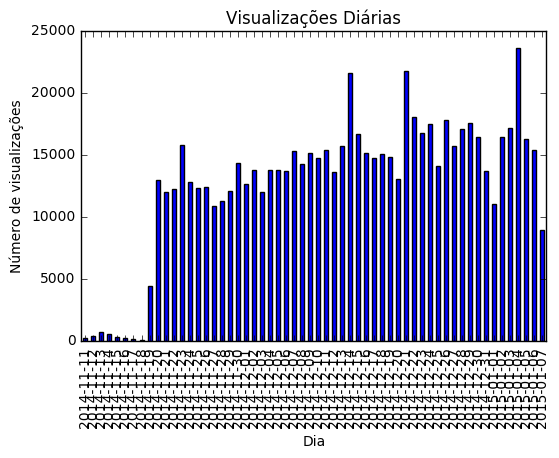

In [32]:
#copia df para conversão de datas
DATE_video_views = NORM_video_views

#converte o dataframe de epoch para data
DATE_video_views.ultima_visualizacao = pd.to_datetime(NORM_video_views.ultima_visualizacao, unit='ms')

#agrupa pela data da ultima visualização (considerando-se apenas o dia)
grouped_date = DATE_video_views.groupby(DATE_video_views.ultima_visualizacao.dt.date)

grouped_date_size = grouped_date.size()

grouped_date_size.plot(kind='bar')
plt.title('Visualizações Diárias')
plt.xlabel('Dia');
plt.ylabel('Número de visualizações');
plt.show()

## Create a cvs file to use with Collaborative Filtering

In [34]:
#seleciona somente os usuários com 20 ou mais visualizações
CF_user = grouped_user_size[grouped_user_size.values >= 20]

#copia somente dados dos usuários que possuem pelo menos 20 views
CF_video_views = NORM_video_views[NORM_video_views.usuario_id.isin(CF_user.index)]

#cria um sistema de notas para a porcentagem vista
#se o usuário assistiu o vídeo 2 vezes ou mais, então ele gostou muito, nota = 3
CF_video_views.loc[CF_video_views.porcentagem_vista >= 2.0, 'porcentagem_vista'] = 3

#se o usuário assistiu x% do vídeo com 70% <= x < 200%, então o usuário gostou do vídeo, nota = 2
CF_video_views.loc[(CF_video_views.porcentagem_vista >= 0.7) & (CF_video_views.porcentagem_vista < 2.0), 'porcentagem_vista'] = 2

#se o usuário assistiu menos de 70% do vídeo, ele não gostou muito, nota = 1
CF_video_views.loc[CF_video_views.porcentagem_vista < 0.7, 'porcentagem_vista'] = 1

#verifica a quantidade de usuários (rows) e vídeos (columns) distintos para configurar a matriz de ratings
rows = CF_video_views.usuario_id.unique()
columns = CF_video_views.video_id.unique()

print("Preparando a indexação da matriz, isso pode levar uns minutinhos, mas só necessita ser feito uma vez...")

#mapeia os ids de usuário e vídeo para indices inteiros a serem utilizados na matriz de ratings
#esse mapeamento é realizado para facilitar a indexação no restante do código
for y in range(columns.shape[0]):
    CF_video_views.video_id = CF_video_views.video_id.replace(columns[y], y)

print("Só mais um pouquinho =)")

for x in range(rows.shape[0]):
    CF_video_views.usuario_id = CF_video_views.usuario_id.replace(rows[x], x)

print("Matriz indexada!")

#grava arquivos csv
rows = pd.DataFrame(data=rows)
columns = pd.DataFrame(data=columns)
rows.to_csv('../data/rows.csv')
columns.to_csv('../data/columns.csv')
CF_video_views.to_csv('../data/sgd_video_views.csv', index = False)

CF_video_views.shape

/home/guilherme/anaconda3/lib/python3.5/site-packages/pandas/core/indexing.py:465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/home/guilherme/anaconda3/lib/python3.5/site-packages/pandas/core/generic.py:2701: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


Preparando a indexação da matriz, isso pode levar uns minutinhos, mas só necessita ser feito uma vez...
Só mais um pouquinho =)
Matriz indexada!


(187737, 4)

(2283,)
(228543,)
